Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


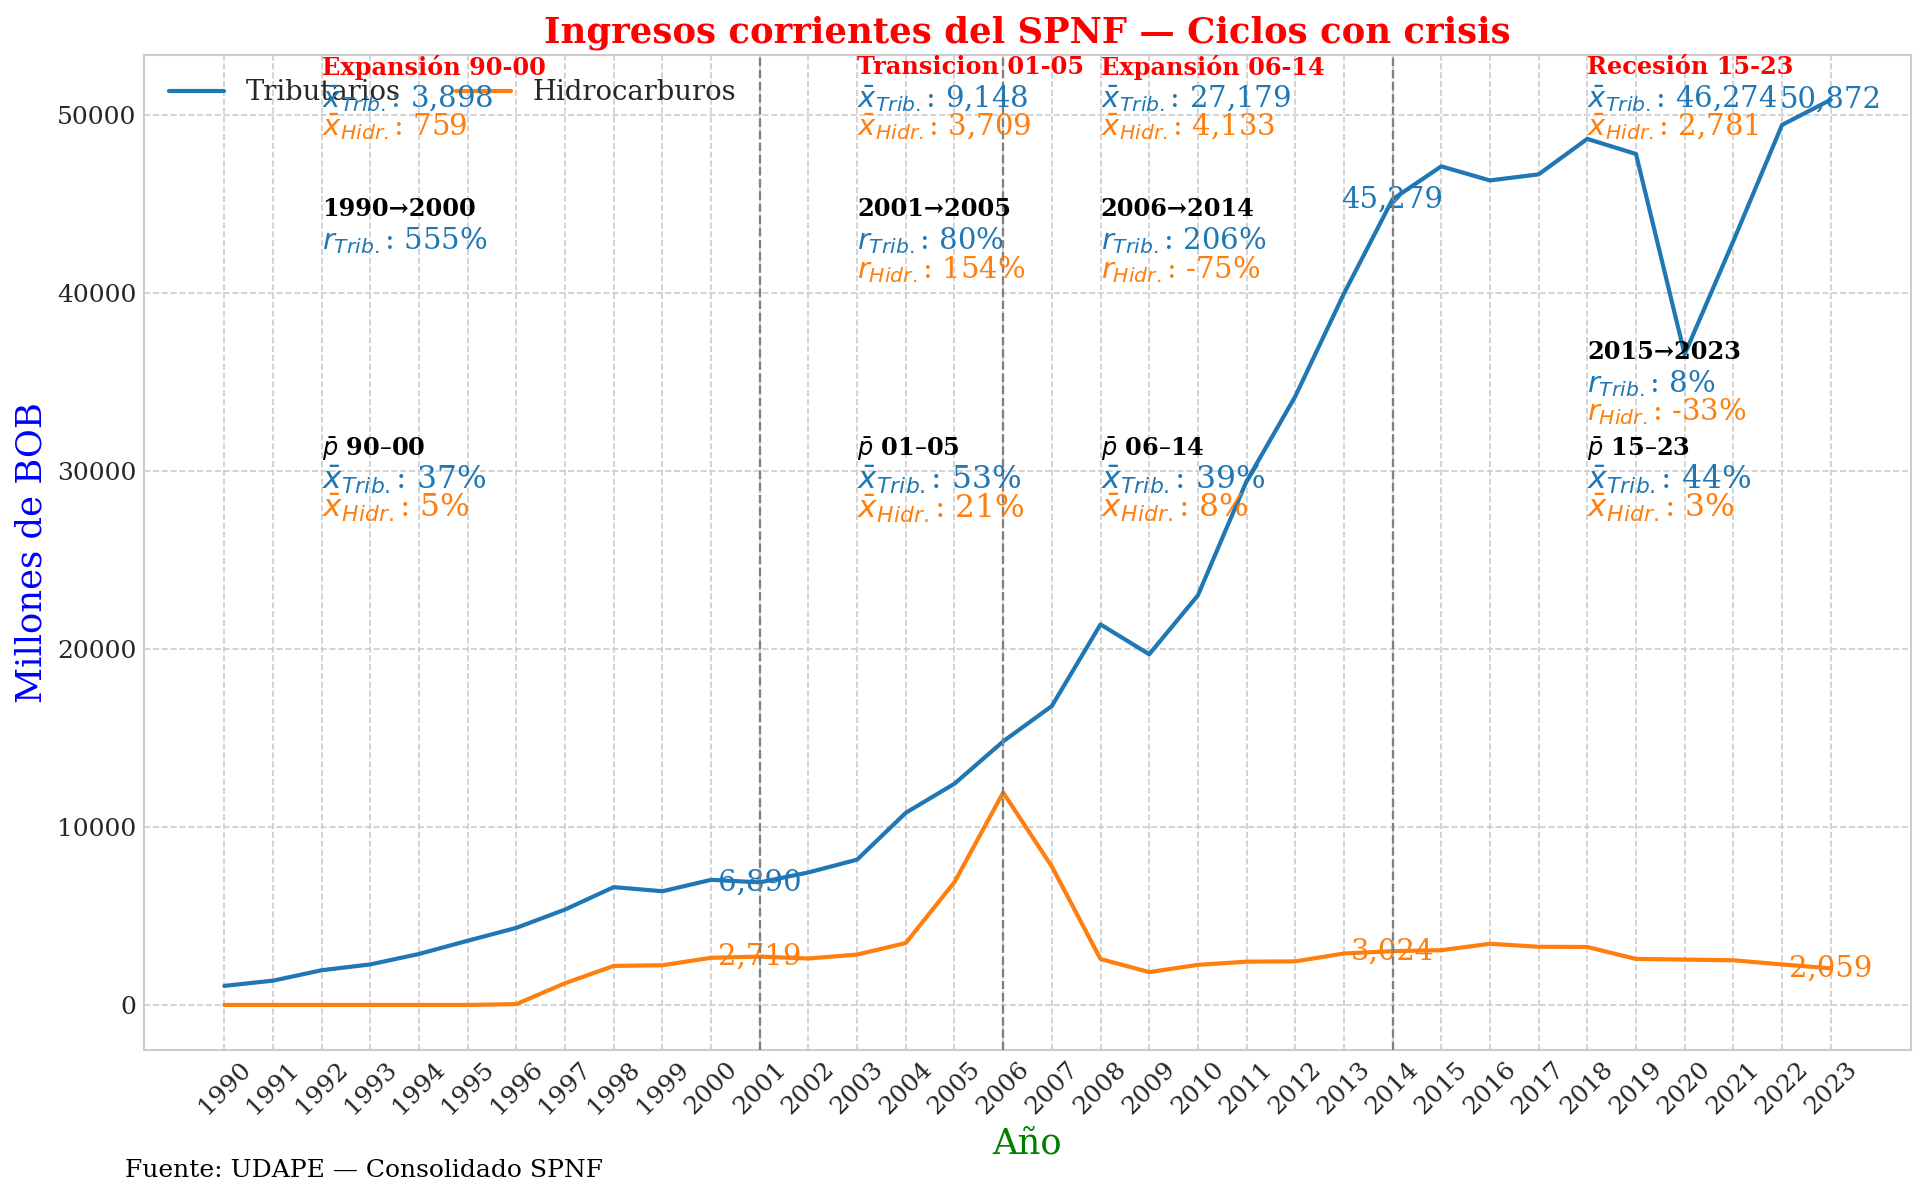

In [1]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones comunes
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# utilidades propias
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    set_style, init_base_plot, get_df,
    add_hitos, add_year_value_annotations,
    add_cycle_means_multi, add_period_growth_annotations_multi,
    add_participation_cycle_boxes,
    adjust_annot_years, adjust_cycles, adjust_periods,
)
from config import (
    # GRÁFICA 1 (con crisis)
    CYCLES, annot_years, periodos_tasas, hitos_v,
    # GRÁFICA 2 (sin crisis)
    CYCLES_SIN_CRISIS, annot_years_sin_crisis, periodos_tasas_sin_crisis, hitos_v_sin_crisis,
    # GRÁFICA 3 (periodos estructurales)
    CYCLES_PERIODOS, annot_years_periodos, periodos_tasas_periodos, hitos_v_periodos,
)

# Directorio de salida
output_dir = "../../../../assets/tesis/serie_completa/ingresos_corrientes"
os.makedirs(output_dir, exist_ok=True)

set_style()

# %%
# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
SQL = """
    SELECT año,
           ingresos_tributarios,
           ingresos_hidrocarburos,
           total_ingresos_corrientes
    FROM ingresos_corrientes
"""
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df_inc = (
        pd.read_sql(SQL, conn, index_col='año')
          .sort_index()
    )

# Componentes y colores
componentes = [
    ("ingresos_tributarios",    "Tributarios"),
    ("ingresos_hidrocarburos",  "Hidrocarburos"),
]
cols_componentes = [c for c, _ in componentes]
custom_colors = {
    "ingresos_tributarios":   "#1f77b4",  # azul
    "ingresos_hidrocarburos": "#ff7f0e",  # naranja
}
abbr_map = {
    "ingresos_tributarios":   "Trib.",
    "ingresos_hidrocarburos": "Hidr.",
}

# Helper para participation
TOTAL_COL = "total_ingresos_corrientes"

# %%
# ============================================================
# 1) GRÁFICA CON CRISIS
# ============================================================
annot_years_crisis = adjust_annot_years(df_inc, annot_years)
cycles_stats_crisis = {
    n: df_inc.loc[s, cols_componentes].mean().to_dict()
    for n, s in adjust_cycles(df_inc, CYCLES).items()
}
periodos_crisis = adjust_periods(df_inc, periodos_tasas)

# Offsets (iniciales, ajusta si solapan)
annotation_offsets = {
    'ingresos_tributarios':   {1982: (0, 0), 1986: (0, 0), 2001: (0, 0), 2014: (0, 0), 2023: (0, 0)},
    'ingresos_hidrocarburos': {1982: (0, 0), 1986: (0, 0), 2001: (0, 0), 2014: (0, 0), 2023: (0, 0)},
}
hitos_offset = {a: 0.85 for a in hitos_v}
medias_offsets = {
    'Expansión 90-00': (1992, 1),
    'Transicion 01-05':    (2003, 1),
    'Expansión 06-14': (2008, 1),
    'Recesión 15-23':  (2018, 1),
}
tasas_offsets = {
    '1990-2000': (1992, 0.85),
    '2001-2005': (2003, 0.85),
    '2006-2014': (2008, 0.85),
    '2015-2023': (2018, 0.70),
}
participation_offsets = {k: (v[0], 0.60) for k, v in tasas_offsets.items()}

fig, ax = init_base_plot(
    df_inc, componentes, custom_colors,
    "Ingresos corrientes del SPNF — Ciclos con crisis",
    "Año", "Millones de BOB",
    source_text="Fuente: UDAPE — Consolidado SPNF"
)
add_hitos(ax, df_inc.index, hitos_v, hitos_offset)
add_year_value_annotations(ax, df_inc, annot_years_crisis,
                           cols_componentes, annotation_offsets,
                           custom_colors, arrow_lw=0.4)
add_cycle_means_multi(ax, cycles_stats_crisis, medias_offsets,
                      abbr_map, custom_colors,
                      line_spacing=ax.get_ylim()[1]*0.03)
add_period_growth_annotations_multi(ax, df_inc, periodos_crisis,
                                    cols_componentes, tasas_offsets,
                                    custom_colors, abbr_map)
add_participation_cycle_boxes(
    ax, df_inc, periodos_crisis,
    cols_componentes, TOTAL_COL,
    participation_offsets, abbr_map=abbr_map,
    colors=custom_colors
)
plt.savefig(os.path.join(output_dir, "ingresos_corrientes_crisis.png"))
plt.show(); plt.close()
